# Including clouds

Let's first make some useful imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from petitRADTRANS import physical_constants as cst
from petitRADTRANS.physics import temperature_profile_function_guillot_global
from petitRADTRANS.radtrans import Radtrans

Let's now instantiate a `Radtrans` object in the usual way, see ["Getting Started"](getting_started.html).

In [2]:
atmosphere = Radtrans(
    pressures = np.logspace(-6, 2, 100),
    line_species = [
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species = ['H2', 'He'],
    gas_continuum_contributors = ['H2-H2', 'H2-He'],
    wavelength_boundaries = [0.3, 15]
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable

Next we set up the atmospheric parameters, with a parameter selection identical to the ["Getting Started"](getting_started.html) case.

In [3]:
planet_radius = 1.0 * cst.r_jup_mean
reference_gravity = 10 ** 3.5
reference_pressure = 0.01

pressures = atmosphere.pressures * 1e-6 # cgs to bar
infrared_mean_opacity = 0.01
gamma = 0.4
intrinsic_temperature = 200
equilibrium_temperature = 1500

temperatures = temperature_profile_function_guillot_global(
    pressures=pressures, 
    infrared_mean_opacity=infrared_mean_opacity, 
    gamma=gamma,
    gravities=reference_gravity, 
    intrinsic_temperature=intrinsic_temperature,
    equilibrium_temperature=equilibrium_temperature
)

mass_fractions = {
    'H2': 0.74 * np.ones_like(temperatures), 
    'He': 0.24 * np.ones_like(temperatures),
    'H2O': 1e-3 * np.ones_like(temperatures), 
    'CO-NatAbund': 1e-2 * np.ones_like(temperatures),
    'CO2': 1e-5 * np.ones_like(temperatures), 
    'CH4': 1e-6 * np.ones_like(temperatures),
    'Na': 1e-5 * np.ones_like(temperatures), 
    'K': 1e-6 * np.ones_like(temperatures)
}

mean_molar_masses = 2.33 * np.ones_like(temperatures)

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive), and the mean molecular mass in atomic mass units. They will be converted to cgs units within the code.
</div>

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** remember that abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the mass of a single molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

Let's now calculate a clear **transmission** spectrum, for reference. An example for the emission case is available in the ["Emission spectra" section](#Emission-spectra).

In [4]:
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure
)
transit_radii_clear = transit_radii / cst.r_jup_mean

## Gray cloud deck

Now, let's calculate cloudy spectra! The simplest way to add a cloud-like effect in petitRADTRANS is to add an opaque gray cloud deck. To do this, use the argument `opaque_cloud_top_pressure` (in bar).

<div class="alert alert-warning">

**Do not use this gray cloud deck implementation if you calculate pRT emission spectra in scattering mode**. We increase the opacity to a **very** high value,  $10^{99}$ cm^2/g, at pressures > cloud top pressure. This can mess with the matrix inversion method used during the flux calculation. Please use [the treatment explained here](#Defining-arbitrary-opacity-functions-(can-be-used-to-parameterize-clouds)) to define your own custom gray opacity in this case.
</div>

In [5]:
# Opaque gray cloud deck at 0.01 bar
wavelengths, transit_radii_gray_cloud, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    opaque_cloud_top_pressure=0.01  # (bar)
)

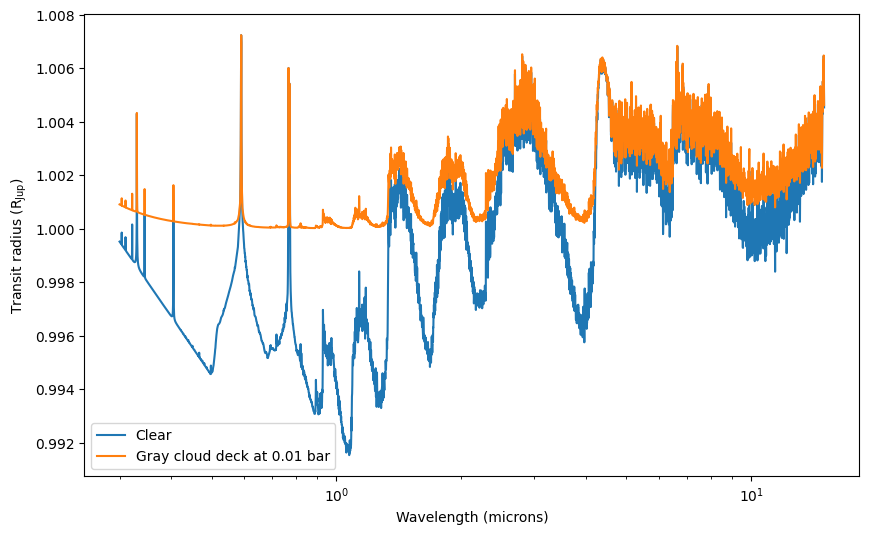

In [6]:
# Plot the spectra
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths * 1e4, transit_radii_clear, label='Clear')
ax.plot(wavelengths * 1e4, transit_radii_gray_cloud / cst.r_jup_mean, label='Gray cloud deck at 0.01 bar')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend()

## Scaled Rayleigh scattering

It is also possible to mimick hazes effects by scaling the Rayleigh scattering opacities of the gas by a given factor, using the `haze_factor` argument.

In [7]:
# Haze (10 x gas Rayleigh scattering)
wavelengths, transit_radii_hazy, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    haze_factor=10.0
)

This can be combined with the [gray cloud deck](#Gray-cloud-deck).

<div class="alert alert-info">

Technically, any of the methods to include clouds presented here can be combined, although it does not necessarily makes sense to do so.
</div>

In [8]:
# Haze + cloud deck
wavelengths, transit_radii_cloud_haze, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    opaque_cloud_top_pressure = 0.01,
    haze_factor=10.0
)

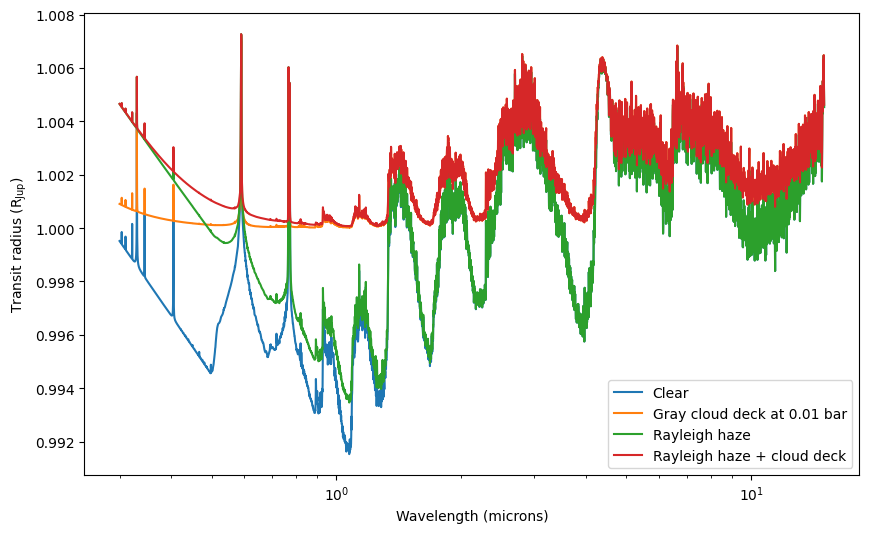

In [9]:
# Plot the spectra
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths * 1e4, transit_radii_clear, label='Clear')
ax.plot(wavelengths * 1e4, transit_radii_gray_cloud / cst.r_jup_mean, label='Gray cloud deck at 0.01 bar')
ax.plot(wavelengths * 1e4, transit_radii_hazy / cst.r_jup_mean, label='Rayleigh haze')
ax.plot(wavelengths * 1e4, transit_radii_cloud_haze / cst.r_jup_mean, label='Rayleigh haze + cloud deck')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend()

## Powerlaw cloud models

The next available mode is the so-called power law cloud. In this case the following opacity is *added* to the scattering cross-section:
\begin{equation}
\kappa = \kappa_0\left(\frac{\lambda}{\lambda_0}\right)^\gamma
\end{equation}
Where $\kappa_0$ is the opacity at a given wavelength (here $\lambda_0=0.35 \ {\rm \mu m}$) in units of cm$^2$/g. The power law index $\gamma$ fixes the wavelength dependence, Rayleigh-like scattering would be obtained for $\gamma=-4$. Hence $\kappa_0$ and $\gamma$ are free parameters.

In petitRADTRANS, $\kappa_0$ is set with the `power_law_opacity_350nm` argument, and $\gamma$ by the `power_law_opacity_coefficient` argument.

<div class="alert alert-warning">

Both `power_law_opacity_350nm` and `power_law_opacity_coefficient` must be set for the power law cloud to take effect.
</div>

We now calculate four power law cloudy models, with $\kappa_0 = 0.01$ cm$^2$/g, and four different $\gamma$ values.

First, $\gamma = -4$ (Rayleigh-like):

In [10]:
power_law_opacity_350nm = 0.01
power_law_opacity_coefficient = -4.0

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    power_law_opacity_350nm=power_law_opacity_350nm,
    power_law_opacity_coefficient=power_law_opacity_coefficient
)

transit_radii_gamma_m4 = transit_radii / cst.r_jup_mean

Second, $\gamma = -2$ (weaker scattering power law):

In [11]:
power_law_opacity_350nm = 0.01
power_law_opacity_coefficient = -2.0

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    power_law_opacity_350nm=power_law_opacity_350nm,
    power_law_opacity_coefficient=power_law_opacity_coefficient
)

transit_radii_gamma_m2 = transit_radii / cst.r_jup_mean

Third, $\gamma = 0$ (flat opacity):

In [12]:
power_law_opacity_350nm = 0.01
power_law_opacity_coefficient = 0.0

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    power_law_opacity_350nm=power_law_opacity_350nm,
    power_law_opacity_coefficient=power_law_opacity_coefficient
)

transit_radii_gamma0 = transit_radii / cst.r_jup_mean

Fourth, the exoctic case of, $\gamma = 1$ (positive opacity slope):

In [13]:
power_law_opacity_350nm = 0.01
power_law_opacity_coefficient = 1.0

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    power_law_opacity_350nm=power_law_opacity_350nm,
    power_law_opacity_coefficient=power_law_opacity_coefficient
)

transit_radii_gamma_p1 = transit_radii / cst.r_jup_mean

Let's now make the plots.

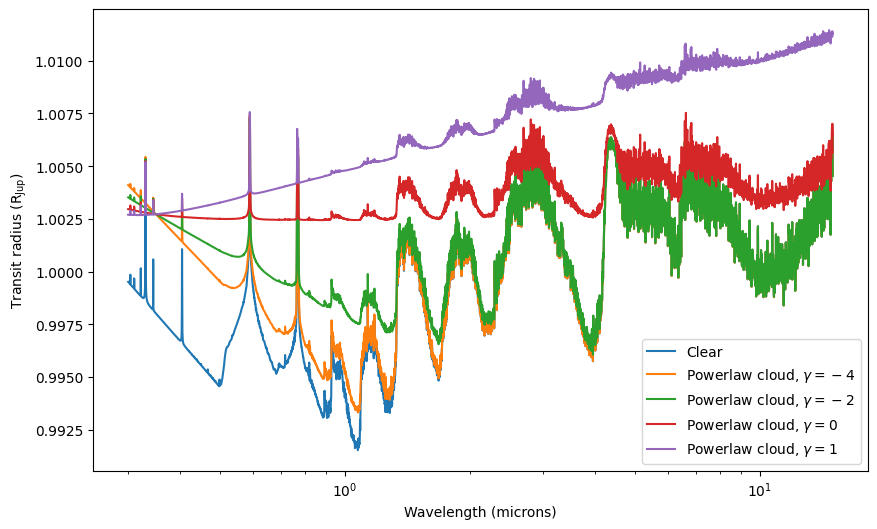

In [14]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(wavelengths * 1e4, transit_radii_clear, label='Clear')
ax.plot(wavelengths * 1e4, transit_radii_gamma_m4, label=r'Powerlaw cloud, $\gamma = -4$')
ax.plot(wavelengths * 1e4, transit_radii_gamma_m2, label=r'Powerlaw cloud, $\gamma = -2$')
ax.plot(wavelengths * 1e4, transit_radii_gamma0, label=r'Powerlaw cloud, $\gamma = 0$')
ax.plot(wavelengths * 1e4, transit_radii_gamma_p1, label=r'Powerlaw cloud, $\gamma = 1$')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc = 'best')

## Condensate clouds from real optical constants

Let's calculate some spectra using opacities derived from optical constants of various materials.
In this example we will take forsterite, that is, $\rm Mg_2SiO_4$. For the list of available cloud species see ["Available opacity species"](../available_opacities.html).

<div class="alert alert-info">

**Choose your favorite particle setup:** petitRADTRANS offers multiple opacity versions for every given condensate, assuming either spherical (Mie scattering) or irreagularly shaped (DHS method = distribution of hollow spheres) particles. Moreover, opacities assuming a crystalline and/or amorphous internal structure can be used, where available.
</div>

We set up the atmosphere like before, this time loading the opacity of solid (``s``), ``crystalline``, irregularly shaped particles (``DHS`` method). The mode identifier for the $\rm Mg_2SiO_4$ opacity therefore is ``'Mg2SiO4(s)_crystalline__DHS'``. Note that for some species only crystalline or amorphous cross-sections are available.

But now, let's start! We simply give one additional ``cloud_species`` list to the Radtrans object, containing the name of the opacity species we want to use.

In [15]:
atmosphere = Radtrans(
    pressures = np.logspace(-6,2,100),
    line_species = [
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species = ['H2', 'He'],
    gas_continuum_contributors = ['H2-H2', 'H2-He'],
    cloud_species = ['Mg2SiO4(s)_crystalline__DHS'],
    wavelength_boundaries = [0.3, 15]
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable

Next we will setup the amtosphere, with a parameter selection *almost* identical to the ["Getting Started"](getting_started.html) case. We also add the mass fraction of the cloud species we are interested in now.

In [16]:
mass_fractions = {
    'H2': 0.74 * np.ones_like(temperatures), 
    'He': 0.24 * np.ones_like(temperatures),
    'H2O': 1e-3 * np.ones_like(temperatures), 
    'CO-NatAbund': 1e-2 * np.ones_like(temperatures),
    'CO2': 1e-5 * np.ones_like(temperatures), 
    'CH4': 1e-6 * np.ones_like(temperatures),
    'Na': 1e-5 * np.ones_like(temperatures), 
    'K': 1e-6 * np.ones_like(temperatures),
    'Mg2SiO4(s)_crystalline__DHS': 0.0000005 * np.ones_like(temperatures)
}

### Setting the cloud particles size

We have to define a few additional parameters for the clouds, to start the calculation. Since we here assume a log-normal paricle size distribution, we give the mean particle size and width of the distribution:

In [17]:
# Here the cloud particles mean radii are vertically constant, but they can vary with pressure as well
cloud_particles_mean_radii = {'Mg2SiO4(s)_crystalline__DHS':  5e-5 * np.ones_like(temperatures)}  # (cm) i.e. 0.5 um
cloud_particle_radius_distribution_std = 1.05  # a value of 1.0 would be a delta function, so we assume a very narrow distribtion here

Now, let's calculate a clear and cloudy spectrum to compare:

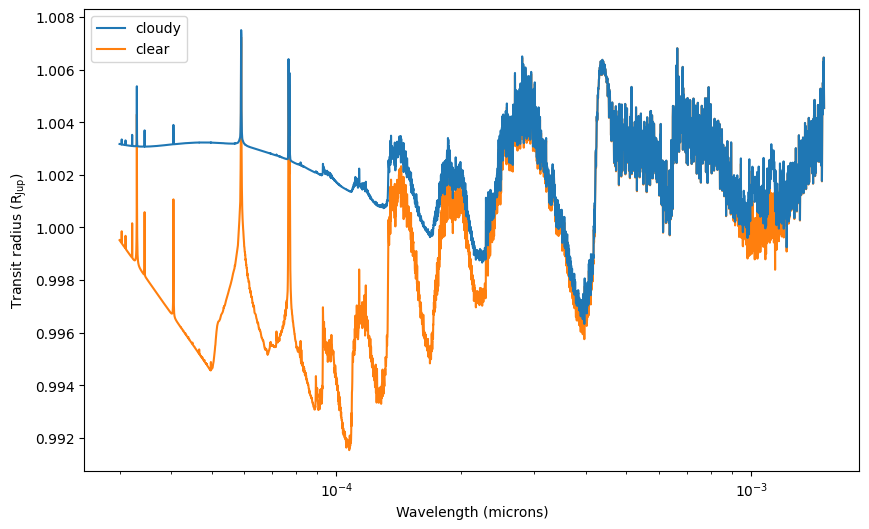

In [18]:
fig, ax = plt.subplots(figsize = (10,6))

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    cloud_particles_mean_radii=cloud_particles_mean_radii,
    cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std
)

ax.plot(wavelengths, transit_radii / cst.r_jup_mean, label='cloudy', zorder=2)

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = np.zeros_like(temperatures)

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    cloud_particles_mean_radii=cloud_particles_mean_radii,
    cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std
)

ax.plot(wavelengths, transit_radii / cst.r_jup_mean, label='clear', zorder=1)

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc='best')

Here one sees that there is a lot of additional absorption in the optical and near-IR. Also note the silicate (Si-O stretching mode) becoming visible at 10 micron.

### Calculating the cloud particles size

#### Fixed settling parameter

Below we will not predefine the particle size. Instead we will calculate it with the "Eddysed" approach presented in [Ackerman & Marley (2001)](https://ui.adsabs.harvard.edu/abs/2001ApJ...556..872A/abstract). For this, one specifies an eddy diffusion coefficient ($K_{zz}$, with units of cm$^2$/s), which describes the strength of vertical atmospheric mixing. The cloud particle size is then controlled by $K_{zz}$, and the unitless settling parameter $f_{\rm sed}$, which expresses the particles' mass averaged settling velocity, when compared to the local atmospheric mixing speed. Also, a width for the log-normal particle size distribution must be specified. Here we use an atmospheric structure almost identical to the one above, with the difference that we also add amorphous and spherical iron cloud particles (``'Fe(s)_amorphous__Mie'``).

In [19]:
atmosphere = Radtrans(
    pressures = np.logspace(-6,2,100),
    line_species = [
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species = ['H2', 'He'],
    gas_continuum_contributors = ['H2-H2', 'H2-He'],
    cloud_species = [
        'Mg2SiO4(s)_crystalline__DHS',
        'Fe(s)_amorphous__Mie'
    ],
    wavelength_boundaries = [0.3, 15]
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable

Here we define the eddy diffusion parameters. Below we use different $f_{\rm sed}$ for the two different cloud species:
```
cloud_f_sed = {
    'Mg2SiO4(s)_crystalline__DHS': 2.0,
    'Fe(s)_amorphous__Mie': 3.0
}
```
If all the clouds should use the same $f_{\rm sed}$ we can just set:
```
cloud_f_sed = 2.0
```

In [20]:
eddy_diffusion_coefficients = np.ones_like(temperatures) * 10 ** 7.5
cloud_f_sed = {
    'Mg2SiO4(s)_crystalline__DHS': 2.0, 
    'Fe(s)_amorphous__Mie': 3.0
}

# We still assume a log-normal particle size distribution:
cloud_particle_radius_distribution_std = 1.05

Again, let's calculate a clear and cloudy spectrum to compare:

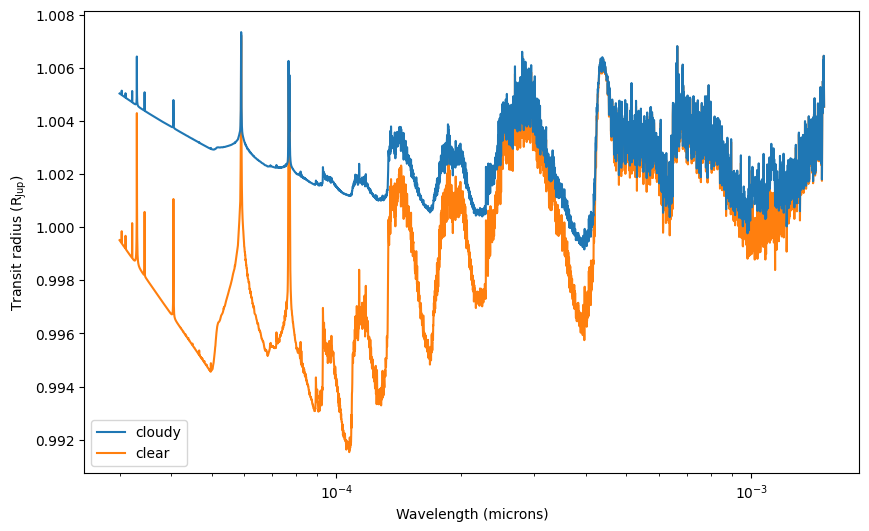

In [21]:
fig, ax = plt.subplots(figsize = (10,6))

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 5e-7 * np.ones_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = 5e-7 * np.ones_like(temperatures)

wavelengths, transit_radii, additional_output = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std
)

ax.plot(wavelengths, transit_radii / cst.r_jup_mean, label='cloudy', zorder=2)

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = np.zeros_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = np.zeros_like(temperatures)

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std=cloud_particle_radius_distribution_std
)

ax.plot(wavelengths, transit_radii/cst.r_jup_mean, label = 'clear', zorder = 1)

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc='best')

The resulting mean particle sizes can be accessed like this:

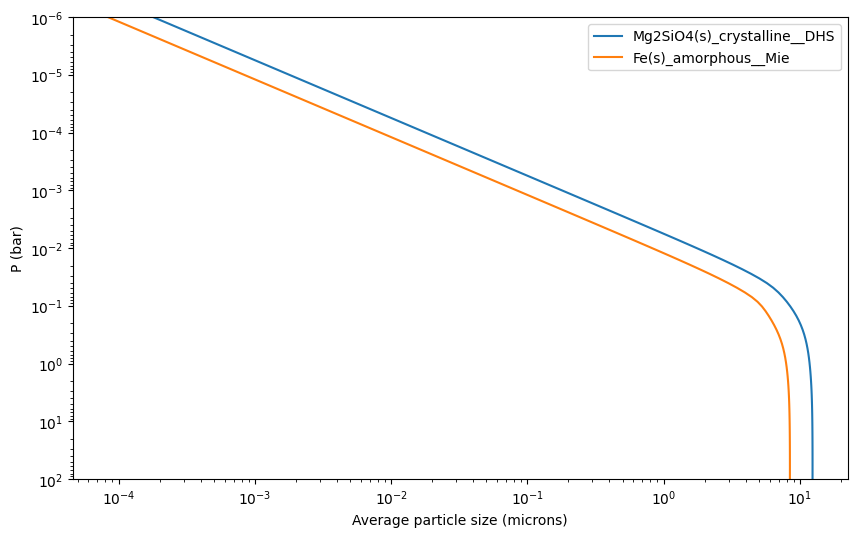

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim([1e2, 1e-6])

ax.set_ylabel('P (bar)')
ax.set_xlabel('Average particle size (microns)')

for i_cloud in range(len(atmosphere.cloud_species)):
    ax.plot(
        additional_output['cloud_particles_mean_radii'][:,i_cloud] * 1e4,
        atmosphere.pressures * 1e-6,
        label=atmosphere.cloud_species[i_cloud]
    )

plt.legend()

<div class="alert alert-warning">

**Particle sizes:** the opacity of particles smaller than 1 nm and larger than 10 cm is set to zero.

</div>

#### Vertically variable settling parameter

If you want you can also make `cloud_f_sed` vertically variable, here we set it vertically constant first and then scale it by scaling_factor_fsed.

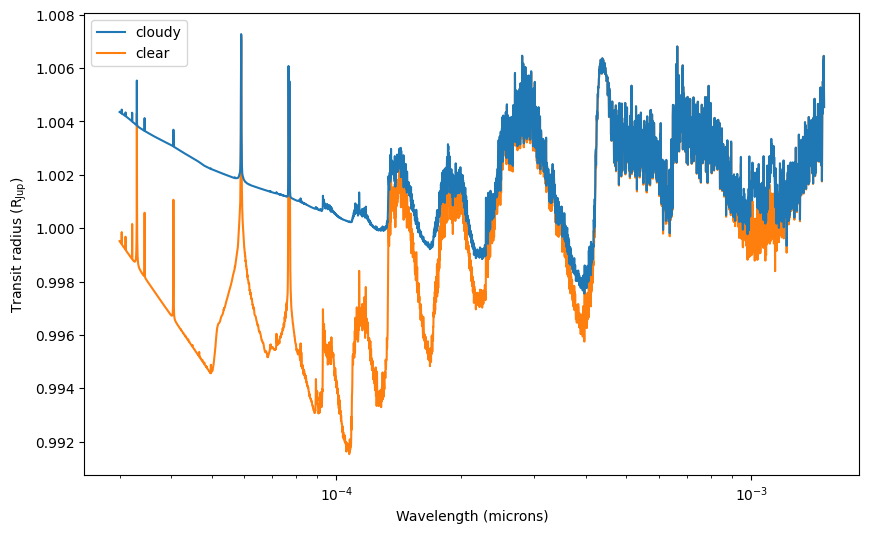

In [23]:
eddy_diffusion_coefficients = np.ones_like(temperatures)*10 ** 7.5
scaling_factor_fsed = np.ones_like(temperatures)
scaling_factor_fsed[atmosphere.pressures * 1e-6 < 1e-1] = 0.1
cloud_f_sed = {
    'Mg2SiO4(s)_crystalline__DHS': 2.0 * np.ones_like(temperatures) * scaling_factor_fsed,
    'Fe(s)_amorphous__Mie': 3.0 * np.ones_like(temperatures) * scaling_factor_fsed
}

# We still assume a log-normal particle size distribution:
cloud_particle_radius_distribution_std = 1.05

fig, ax = plt.subplots(figsize = (10, 6))

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 5e-7 * np.ones_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = 5e-7 * np.ones_like(temperatures)

wavelengths, transit_radii, additional_output = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std
)

ax.plot(wavelengths, transit_radii / cst.r_jup_mean, label='cloudy', zorder=2)

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = np.zeros_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = np.zeros_like(temperatures)

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std=cloud_particle_radius_distribution_std
)

ax.plot(wavelengths, transit_radii / cst.r_jup_mean, label='clear', zorder=1)

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc='best')

The resulting radii are smaller for pressures smaller than 0.1 bar.

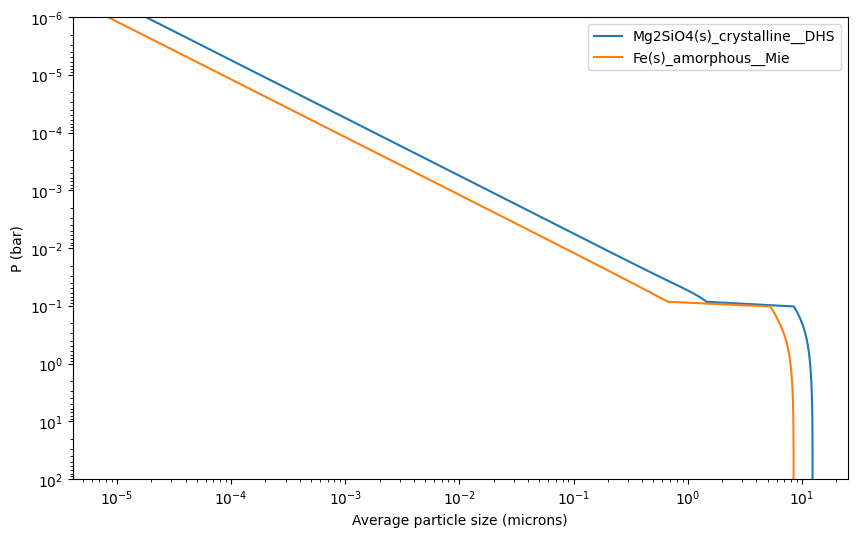

In [24]:
fig, ax = plt.subplots(figsize = (10,6))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim([1e2, 1e-6])

ax.set_ylabel('P (bar)')
ax.set_xlabel('Average particle size (microns)')

for i_cloud in range(len(atmosphere.cloud_species)):
    ax.plot(
        additional_output['cloud_particles_mean_radii'][:,i_cloud] * 1e4,
        atmosphere.pressures * 1e-6,
        label=atmosphere.cloud_species[i_cloud]
    )

plt.legend()

### Hansen Distribution Clouds

While the EddySed model used here typically uses a log-normal distribution for the cloud particle radii, it is also possible to use the [Hansen (1971)](http://web.gps.caltech.edu/~vijay/Papers/Polarisation/hansen-71b.pdf) distribution. To do this, you'll need to set the `cloud_particles_radius_distribution` parameter in `calculate_flux()` or `calculate_transmission()` to `'hansen'`, and set the effective width of the distribution with the `cloud_hansen_b` parameter. Alternately, you can specify both the distribution width and center using the `cloud_hansen_b` and `cloud_hansen_a` arguments. Note that the value of `cloud_hansen_b` will be different from that of `cloud_particle_radius_distribution_std` to give a similar distribution, because the effective width is weighted by the particle area. See Hansen (1971) for more details.

Here, we'll calculate the mean particle size as a function of altitude, so `cloud_hansen_a` is not used. We will also look at the particle sizes again.

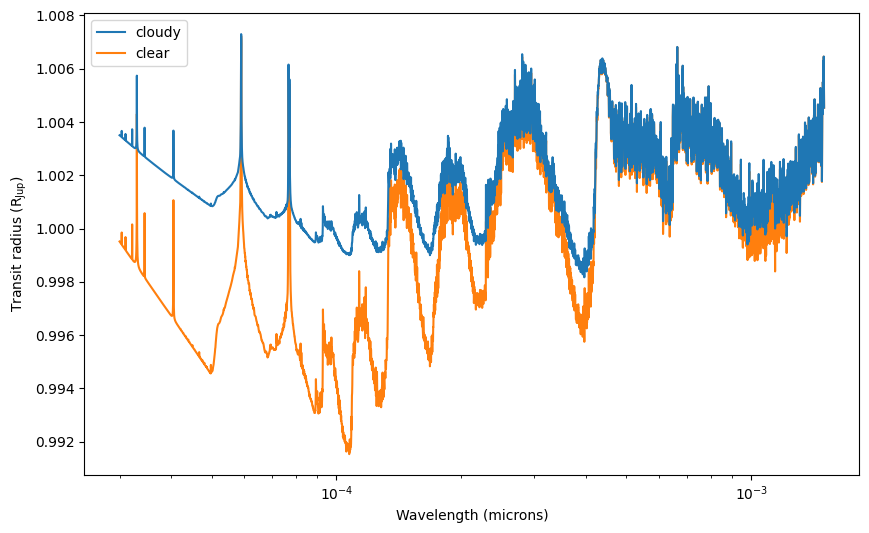

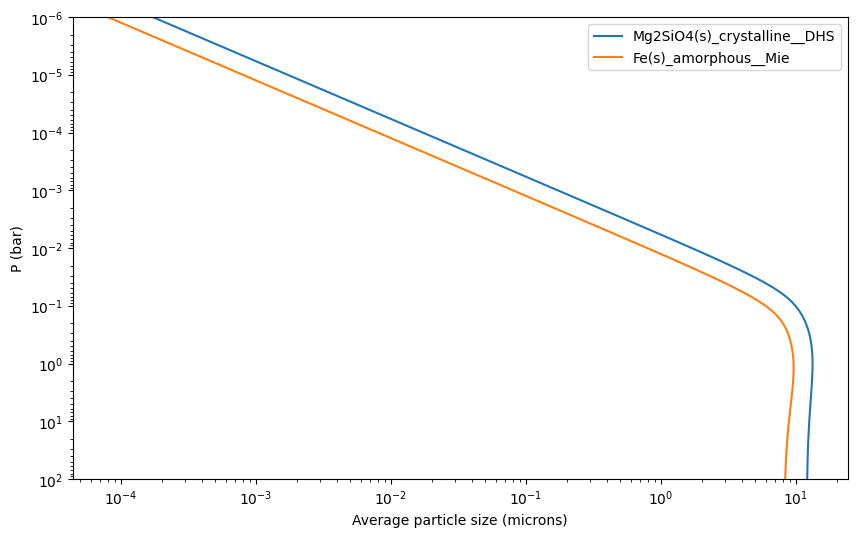

In [25]:
fig, ax = plt.subplots(figsize = (10, 6))

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 5e-7 * np.ones_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = 5e-7 * np.ones_like(temperatures)

eddy_diffusion_coefficients = np.ones_like(temperatures) * 10 ** 7.5
cloud_f_sed = {
    'Mg2SiO4(s)_crystalline__DHS': 2.0,
    'Fe(s)_amorphous__Mie': 3.0
}
cloud_particle_radius_distribution_std = 1.05

cloud_hansen_b = 0.01

wavelengths, transit_radii, additional_output = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std=cloud_particle_radius_distribution_std,
    cloud_particles_radius_distribution='hansen',
    cloud_hansen_b=cloud_hansen_b
)


ax.plot(wavelengths, transit_radii / cst.r_jup_mean, label='cloudy', zorder=2)

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = np.zeros_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = np.zeros_like(temperatures)

wavelengths, transit_radii, __ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
    cloud_particles_radius_distribution='hansen',
    cloud_hansen_b=cloud_hansen_b
    )

ax.plot(wavelengths, transit_radii / cst.r_jup_mean, label='clear', zorder=1)

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim([1e2, 1e-6])

ax.set_ylabel('P (bar)')
ax.set_xlabel('Average particle size (microns)')

for i_cloud in range(len(atmosphere.cloud_species)):
    ax.plot(
        additional_output['cloud_particles_mean_radii'][:,i_cloud] * 1e4,
        atmosphere.pressures * 1e-6,
        label = atmosphere.cloud_species[i_cloud]
    )

plt.legend()

<div class="alert alert-warning">

**Particle sizes:** the opacity of particles smaller than 1 nm and larger than 10 cm is set to zero.
</div>

## Defining arbitrary opacity functions (can be used to parameterize clouds)

What happens if you have a favorite cloud parameterization, but its implementation is not offered in pRT? Fear not, there is an option for you! When running the method `calculate_transit_radii()` (or `calculate_flux()`) you can hand it any arbitrary function that returns a scattering or absorption opacity as a function of wavelength and pressure to pRT. This is then going to be used in that particular `calculate_transit_radii()` or `calculate_flux()` run. An example can be found below, where we implement the following cloud model:
$$
\kappa_{\rm cloud}(\lambda, P)= \frac{\kappa_0}{1+\left(\lambda/\lambda_0\right)^p} \left(\frac{P}{P_{\rm base}}\right)^{f_{\rm sed}} {\rm \ if \ } P<P_{\rm base}
$$
and $0$ if $P\geq P_{\rm base}$. Here, $\lambda$ and $P$ are the wavelength in micron and pressure in bar, respectively, and $\kappa_0$, $\lambda_0$, $p$, $P_{\rm base}$ and $f_{\rm sed}$ are free parameters, thought to parameterize the opacity (in $\rm cm^2/g$) at the reference wavelength $\lambda_0$, the power law dependence of the opacity with wavelengh at $\lambda \gg \lambda_0$, the cloud base pressure in bar, and the cloud scale height descrease factor, respectively.

Here an example implementation of this cloud model:

In [26]:
def cloud_opas(
    kappa_0,
    lambda_0,
    p,
    p_base,
    f_sed
):
    def get_opacity(wavelengths, pressures):
        """Wavelengths in microns, pressures in bar"""
        opacities = np.zeros((len(wavelengths), len(pressures)))

        for i_p in range(len(pressures)):
            if pressures[i_p] < p_base:
                opacities[:, i_p] = kappa_0 / (1 + (wavelengths / lambda_0) ** p) * (pressures[i_p] / p_base) ** f_sed
            else:
                opacities[:, i_p] = 0.0
        return opacities

    return get_opacity

We can now hand this function to `calculate_transit_radii()` or (`calculate_flux()`). If we want to use it as an absorption opacity, we have to use the `additional_absorption_opacities_function` keyword. If we want to use it as a scattering opacity, we have to use the `additional_scattering_opacities_function` keyword. Note that in the transmission spectrum case the results will not differ between the two options, because both scattering and absorption cross-sections simply contribute to the total extinction opacity.

<div class="alert alert-warning">

The function you hand to pRT has to take in wavelengths in **microns** and pressure in **bar** as input, and return the opacities as a matrix of shape number of wavelengths $\times$ number of pressure layers, identical to how it is implemented above.
</div>



Below some examples:

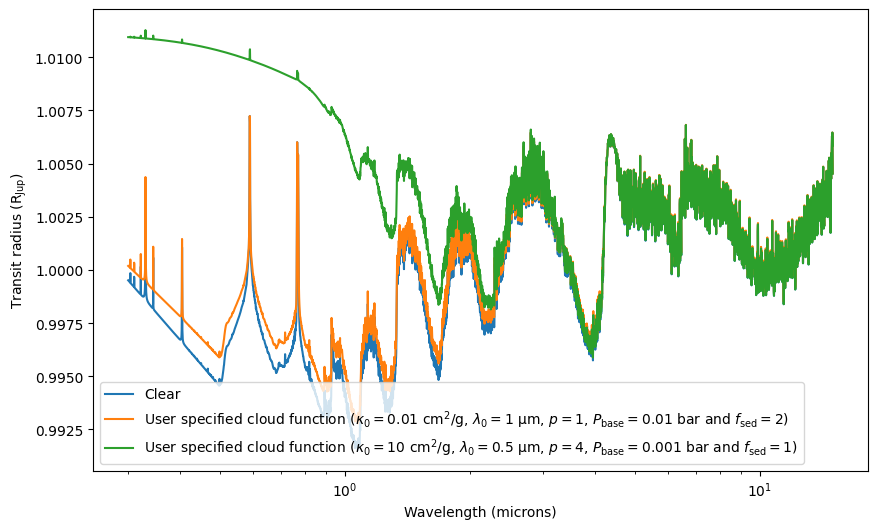

In [27]:
fig, ax = plt.subplots(figsize = (10,6))

# Clear
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure
)

ax.plot(wavelengths * 1e4, transit_radii / cst.r_jup_mean, label='Clear')

# External cloud absorption function, test 1
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    additional_absorption_opacities_function=cloud_opas(1e-2, 1., 1., 0.01, 2)
)

ax.plot(
    wavelengths * 1e4,
    transit_radii / cst.r_jup_mean,
    label=r'User specified cloud function '
          r'$(\kappa_0=0.01 \ {\rm cm^2/g}$, $\lambda_0=1 \ {\rm \mu m}$, $p=1$, '
          r'$P_{\rm base} = 0.01  \ {\rm bar}$ and $f_{\rm sed}=2$)'
)

# External cloud absorption function, test 2
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    additional_absorption_opacities_function=cloud_opas(1e1, 0.5, 4, 0.001, 1)
)
ax.plot(
    wavelengths*1e4,
    transit_radii/cst.r_jup_mean,
    label=r'User specified cloud function '
          r'$(\kappa_0=10 \ {\rm cm^2/g}$, $\lambda_0=0.5 \ {\rm \mu m}$, $p=4$, '
          r'$P_{\rm base} = 0.001  \ {\rm bar}$ and $f_{\rm sed}=1$)'
)

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.legend(loc = 'best')

<div class="alert alert-warning">

If you use this option in correlated-k (`c-k`) mode, please **only** parameterize opacities that vary **slowly enough with wavelength**. Molecular and atomic line opacities, for example, **must not** be added in this way, for these the correlated-k opacity treatment is required. Clouds (even if they have an absorption feature) and other pseudo-continuum opacities such as collision induced absorption (CIA) could be handled well with the treatment above, however.
</div>

## Cloud fraction

All of the examples above were assuming that the observed section of the planet is fully covered by clouds. While this assumption can be reasonable for some planets (e.g. Venus), clouds can sometimes form patches instead (e.g. Jupiter or the Earth). A way to model this is by using a "cloud fraction" ($c_f$) parameter, which combines a clear and a (fully covered) cloudy atmosphere following:

\begin{equation}
F = c_f * F_\mathrm{cloudy} + (1 - c_f) * F_\mathrm{clear}.
\end{equation}

In petitRADTRANS, the cloud fraction can be set by using the `cloud_fraction` argument. The following cloud models are affected:

- The [gray cloud deck](#Gray-cloud-deck).
- The [power law clouds](#Powerlaw-cloud-models).
- The ["physical" clouds](#Condensate-clouds-from-real-optical-constants).
- The [arbitrary opacities](#Defining-arbitrary-opacity-functions-(can-be-used-to-parameterize-clouds)).

<div class="alert alert-info">

The following opacities or cloud models are **not** affected by cloud fraction:

- The [Rayleigh scale factor](#Scaled-Rayleigh-scattering).
- The line opacities.
- The CIA opacities.
- The non-CIA gas continuum opacities.
- The gray opacity (not to be confused with the gray cloud).
- The Rayleigh opacities.
</div>

### Default usage

Below are examples for each of these cases.

In [28]:
cloud_fractions = np.linspace(0, 1, 4)

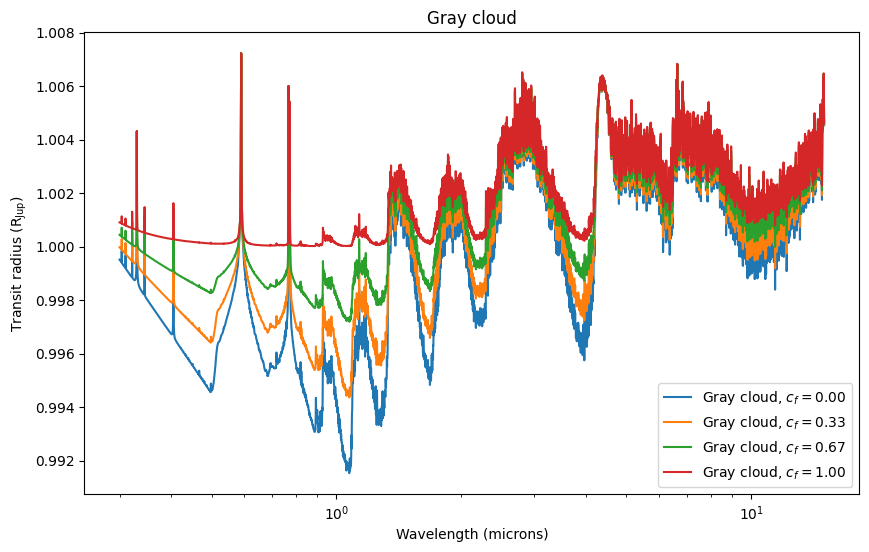

In [29]:
# Gray cloud deck
fig, ax = plt.subplots(figsize = (10,6))

for cloud_fraction in cloud_fractions:
    wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
        temperatures=temperatures, 
        mass_fractions=mass_fractions, 
        mean_molar_masses=mean_molar_masses, 
        reference_gravity=reference_gravity, 
        planet_radius=planet_radius, 
        reference_pressure=reference_pressure,
        opaque_cloud_top_pressure=1e-2,
        cloud_fraction=cloud_fraction
    )
    ax.plot(wavelengths * 1e4, transit_radii / cst.r_jup_mean, label=rf'Gray cloud, $c_f = {cloud_fraction:.2f}$')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.set_title('Gray cloud')
plt.legend()

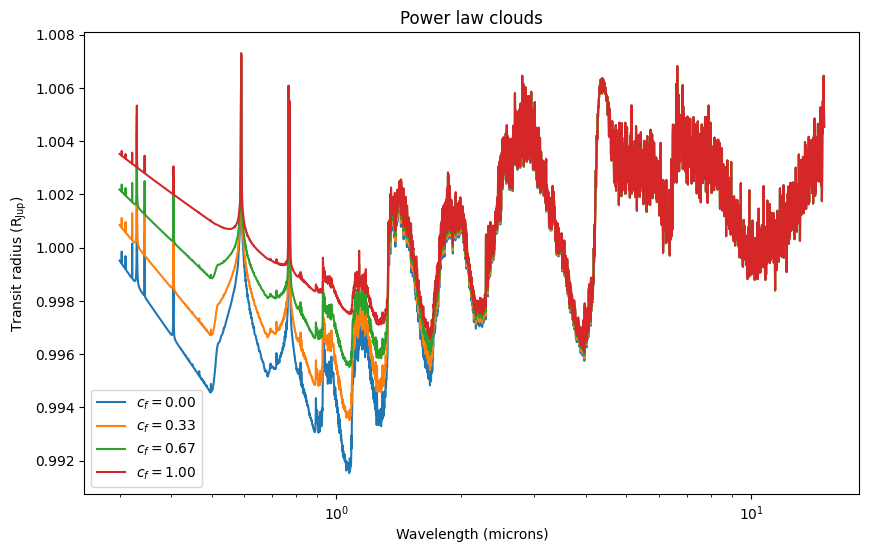

In [30]:
# Power law clouds
fig, ax = plt.subplots(figsize = (10,6))

for cloud_fraction in cloud_fractions:
    wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
        temperatures=temperatures, 
        mass_fractions=mass_fractions, 
        mean_molar_masses=mean_molar_masses, 
        reference_gravity=reference_gravity, 
        planet_radius=planet_radius, 
        reference_pressure=reference_pressure,
        power_law_opacity_350nm=1e-2,
        power_law_opacity_coefficient=-2,
        cloud_fraction=cloud_fraction
    )
    ax.plot(wavelengths * 1e4, transit_radii / cst.r_jup_mean, label=rf'$c_f = {cloud_fraction:.2f}$')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.set_title('Power law clouds')
plt.legend()

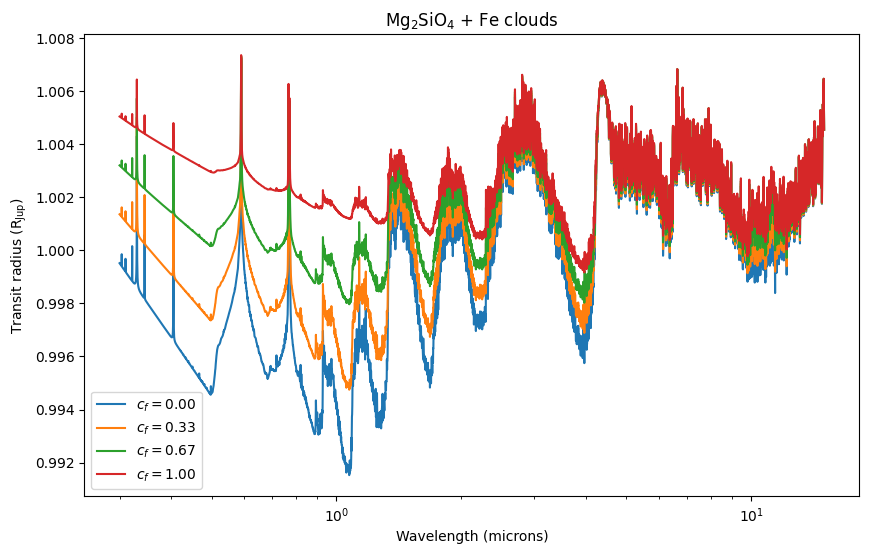

In [31]:
# Physical clouds
fig, ax = plt.subplots(figsize = (10,6))

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 5e-7 * np.ones_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = 5e-7 * np.ones_like(temperatures)

for cloud_fraction in cloud_fractions:
    wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
        temperatures=temperatures, 
        mass_fractions=mass_fractions, 
        mean_molar_masses=mean_molar_masses, 
        reference_gravity=reference_gravity, 
        planet_radius=planet_radius, 
        reference_pressure=reference_pressure,
        eddy_diffusion_coefficients=eddy_diffusion_coefficients,
        cloud_f_sed=cloud_f_sed,
        cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
        cloud_fraction=cloud_fraction
    )
    ax.plot(wavelengths * 1e4, transit_radii / cst.r_jup_mean, label=rf'$c_f = {cloud_fraction:.2f}$')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.set_title(r'Mg$_2$SiO$_4$ + Fe clouds')
plt.legend()

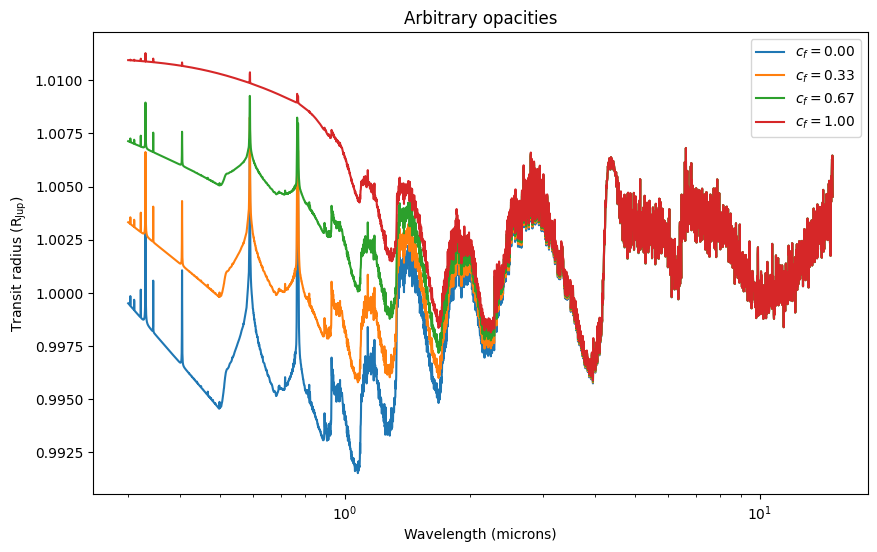

In [32]:
# Arbitrary opacities
fig, ax = plt.subplots(figsize = (10,6))

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 0.0 * np.ones_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = 0.0 * np.ones_like(temperatures)

for cloud_fraction in cloud_fractions:
    wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
        temperatures=temperatures, 
        mass_fractions=mass_fractions, 
        mean_molar_masses=mean_molar_masses, 
        reference_gravity=reference_gravity, 
        planet_radius=planet_radius, 
        reference_pressure=reference_pressure,
        additional_absorption_opacities_function=cloud_opas(1e1, 0.5, 4, 0.001, 1),
        cloud_fraction=cloud_fraction
    )
    ax.plot(wavelengths * 1e4, transit_radii / cst.r_jup_mean, label=rf'$c_f = {cloud_fraction:.2f}$')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.set_title(r'Arbitrary opacities')
plt.legend()

### Control which physical clouds are fractioned

It is also possible to control which physical clouds are affected by the cloud fraction. For example, we can imagine a case where a planet is fully covered by deep, $\rm Fe$ cloud, while $\mathrm{Mg}_2\mathrm{SiO}_4$ clouds form patches in the upper atmosphere. This can be done by using the `complete_coverage_clouds` argument.

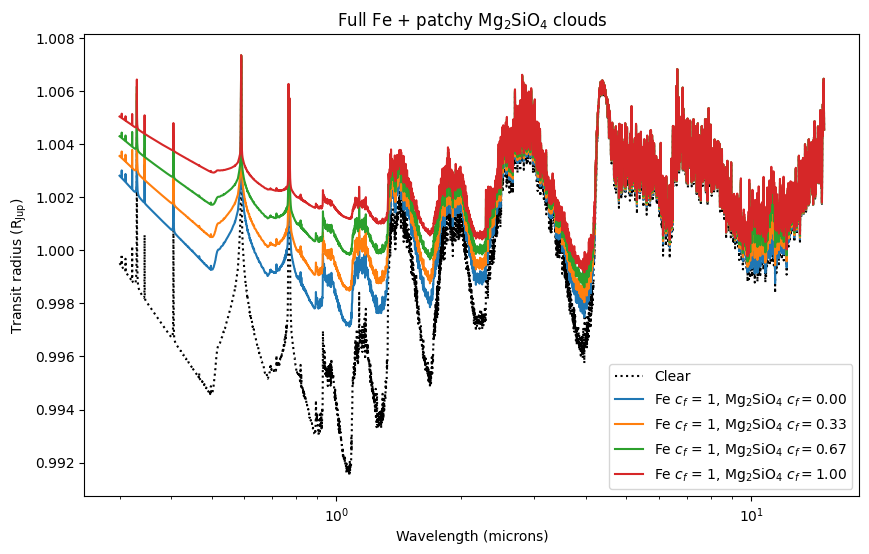

In [33]:
# Full Fe + patchy Mg2SiO4
fig, ax = plt.subplots(figsize = (10,6))

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 5e-7 * np.ones_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = 5e-7 * np.ones_like(temperatures)

ax.plot(wavelengths * 1e4, transit_radii_clear, label=rf'Clear', color='k', ls=':')

for cloud_fraction in cloud_fractions:
    wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
        temperatures=temperatures, 
        mass_fractions=mass_fractions, 
        mean_molar_masses=mean_molar_masses, 
        reference_gravity=reference_gravity, 
        planet_radius=planet_radius, 
        reference_pressure=reference_pressure,
        eddy_diffusion_coefficients=eddy_diffusion_coefficients,
        cloud_f_sed=cloud_f_sed,
        cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std,
        cloud_fraction=cloud_fraction,
        complete_coverage_clouds=['Fe(s)_amorphous__Mie']
    )
    ax.plot(wavelengths * 1e4, transit_radii / cst.r_jup_mean, label=rf'Fe $c_f$ = 1, Mg$_2$SiO$_4$ $c_f = {cloud_fraction:.2f}$')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.set_title(r'Full Fe + patchy Mg$_2$SiO$_4$ clouds')
plt.legend()

## Emission spectra

We can use the Radtrans object created above to calculate emission spectra as well. Here we will also generate an instance of pRT with scattering turned on with ``scattering_in_emission = True``, (see ["Scattering for Emission Spectra"](scattering_for_emission_spectra.html) for an example on how to do this in detail).

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable

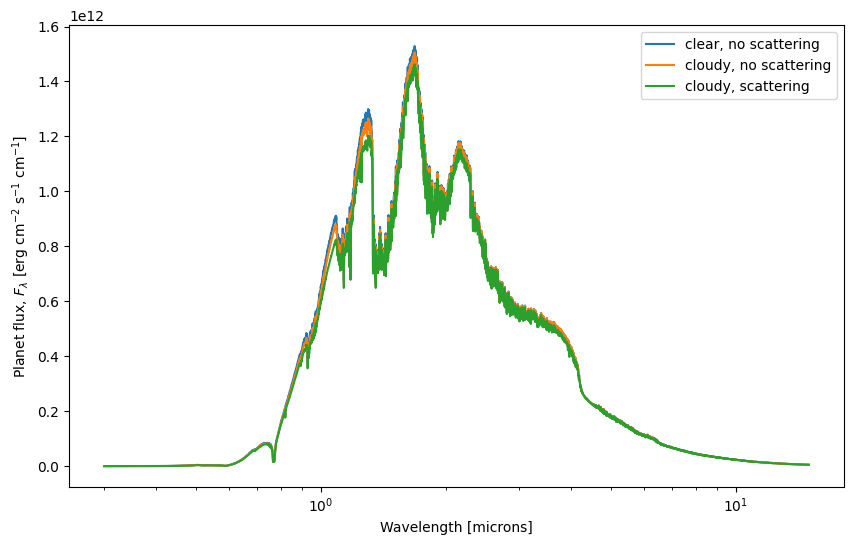

In [34]:
fig, ax = plt.subplots(figsize = (10, 6))

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = np.zeros_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = np.zeros_like(temperatures)

wavelengths, flux, _ = atmosphere.calculate_flux(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std=cloud_particle_radius_distribution_std
)

ax.plot(wavelengths*1e4, flux, label = 'clear, no scattering')

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 5e-7 * np.ones_like(temperatures)
mass_fractions['Fe(s)_amorphous__Mie'] = 5e-7 * np.ones_like(temperatures)

wavelengths, flux, _ = atmosphere.calculate_flux(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std=cloud_particle_radius_distribution_std
    )

ax.plot(wavelengths*1e4, flux, label = 'cloudy, no scattering')
                       
atmosphere_scat = Radtrans(
    pressures = np.logspace(-6,2,100),
    line_species = [
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species = ['H2', 'He'],
    gas_continuum_contributors = ['H2-H2', 'H2-He'],
    cloud_species = [
        'Mg2SiO4(s)_crystalline__DHS',
        'Fe(s)_amorphous__Mie'
    ],
    wavelength_boundaries = [0.3, 15],
    scattering_in_emission=True
)

wavelengths, flux, _ = atmosphere_scat.calculate_flux(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity,
    eddy_diffusion_coefficients=eddy_diffusion_coefficients,
    cloud_f_sed=cloud_f_sed,
    cloud_particle_radius_distribution_std=cloud_particle_radius_distribution_std
)

ax.plot(wavelengths*1e4, flux, label = 'cloudy, scattering')

ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

ax.legend()
plt.show()

Here we plotted the clear spectrum, neglecting the cloud opacity, the cloudy spectrum only considering the absorption of the cloud particles, and the cloudy spectrum with scattering, using the scattering version of pRT.

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** remember that scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](scattering_for_emission_spectra.html) for an example how to do this).
</div>

<div class="alert alert-warning">

**Standard flux units:** before pRT3 flux was accessed as `atmosphere.flux` after running `atmosphere.calc_flux()`, which contained flux as $F_\nu$, so in units of erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$. pRT's `calculate_flux()` method now returns wavelength and flux as $F_\lambda$ in its standard setting, so flux in erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$. To return frequencies and $F_\nu$, instead of wavelengths and $F_\lambda$, please set the keyword `frequencies_to_wavelengths=False` when calling `calculate_flux().`

</div>